# Load dataset

In [ ]:
!pip install kaggle

In [ ]:
import os
import zipfile

def download_data_from_kaggle():
    try:
        from google.colab import files
        uploaded = files.upload()
    except ImportError:
        print("Running outside of Colab. Please ensure your kaggle.json is in ~/.kaggle/")

    if 'kaggle.json' in os.listdir('.'):
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        print("kaggle.json not found. Please upload it or place it in the correct directory.")

    if not os.path.exists('cpe342-karena.zip'):
        print("Downloading data from Kaggle competition 'cpe342-karena'...")
        !kaggle competitions download -c cpe342-karena
    else:
        print("Data already downloaded.")

    if os.path.exists('cpe342-karena.zip'):
        print("Unzipping data...")
        try:
            with zipfile.ZipFile('cpe342-karena.zip', 'r') as zip_ref:
                zip_ref.extractall('.')
            print("Data unzipped.")
        except zipfile.BadZipFile:
            print("Error: Downloaded file is not a valid zip file.")
        except Exception as e:
            print(f"An error occurred during unzipping: {e}")
    else:
        print("Zip file not found, cannot unzip.")

In [ ]:
download_data_from_kaggle()

Saving kaggle.json to kaggle.json
 98% 903M/920M [00:07<00:00, 304MB/s]
100% 920M/920M [00:07<00:00, 121MB/s]
Unzipping data...
Data unzipped.


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier

## Raw data EDA

In [ ]:
df = pd.read_csv('task1/train.csv')
df = df.drop(['id', 'player_id'], axis=1)

In [ ]:
df.head()

,kill_death_ratio,headshot_percentage,win_rate,accuracy_score,kill_consistency,reaction_time_ms,account_age_days,level,level_progression_speed,friend_network_size,reports_received,device_changes_count,input_consistency_score,avg_session_length_min,sessions_per_day,night_play_ratio,weapon_switch_speed,movement_pattern_score,aiming_smoothness,spray_control_score,game_sense_score,communication_rate,team_play_score,buy_decision_score,map_knowledge,clutch_success_rate,first_blood_rate,survival_time_avg,damage_per_round,utility_usage_rate,crosshair_placement,is_cheater
0,4.556072,15.494589,NaN,36.953785,0.737653,NaN,1204.586641,73.364603,0.033039,122.0,NaN,NaN,0.733983,130.540935,3.605662,0.616183,NaN,NaN,0.697074,0.636655,0.979355,0.620589,0.653589,0.860407,0.487273,0.534021,0.321734,NaN,91.517681,0.736361,0.928522,0.0
1,6.177695,51.476210,86.670187,59.946064,NaN,93.748524,3.405453,84.104334,12.211503,0.0,10.0,11.0,0.655691,32.243775,1.864701,0.097047,0.390793,0.524076,1.000000,0.747055,0.942148,0.851946,NaN,0.410925,0.690833,0.151872,0.462196,84.599562,119.212421,0.525739,0.946558,0.0
2,6.584511,51.692578,32.827778,46.545739,0.811803,120.895839,551.221686,43.803175,0.076185,205.0,19.0,11.0,0.823197,257.077532,4.094368,NaN,0.474855,0.655892,0.655245,0.630495,0.775011,0.636306,0.639732,0.619968,0.511507,0.311445,0.270611,83.793333,58.200726,0.739374,0.897872,0.0
3,5.237014,44.181842,62.740475,30.260066,0.345491,248.056545,114.034430,NaN,NaN,75.0,14.0,5.0,0.599739,106.481060,5.102765,0.336917,0.553323,NaN,0.801353,0.739435,0.852695,0.799637,0.766887,0.612241,0.477374,NaN,0.402723,97.518653,121.315491,0.531533,0.860302,1.0
4,2.453744,44.361101,68.296046,27.470153,0.851962,210.530688,153.210944,83.293728,0.354636,79.0,NaN,5.0,0.573104,246.220042,9.337887,0.107388,NaN,0.679243,NaN,0.844987,NaN,0.242936,0.691935,0.653540,0.698389,NaN,0.197220,50.405967,79.110571,0.771739,0.853758,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99872 entries, 0 to 99871
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   kill_death_ratio         97521 non-null  float64
 1   headshot_percentage      84716 non-null  float64
 2   win_rate                 90015 non-null  float64
 3   accuracy_score           96848 non-null  float64
 4   kill_consistency         97281 non-null  float64
 5   reaction_time_ms         73815 non-null  float64
 6   account_age_days         81323 non-null  float64
 7   level                    75795 non-null  float64
 8   level_progression_speed  80614 non-null  float64
 9   friend_network_size      91713 non-null  float64
 10  reports_received         75722 non-null  float64
 11  device_changes_count     90774 non-null  float64
 12  input_consistency_score  82273 non-null  float64
 13  avg_session_length_min   94473 non-null  float64
 14  sessions_per_day      

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
kill_death_ratio,97521.0,4.730992,1.517649,0.500000,3.707266,4.563780,5.535913,12.000000
headshot_percentage,84716.0,47.862476,13.809168,5.000000,38.234664,47.136106,56.593599,95.000000
win_rate,90015.0,71.392377,13.980314,19.072048,61.712798,71.306532,81.002581,100.000000
accuracy_score,96848.0,40.136772,12.132295,8.000000,31.590962,39.582770,48.071852,85.000000
kill_consistency,97281.0,0.648417,0.150941,0.250000,0.543156,0.651803,0.756384,0.980000
reaction_time_ms,73815.0,135.095617,51.168588,55.000000,99.365908,128.520912,162.611524,528.543010
account_age_days,81323.0,496.732778,351.046370,1.025164,158.319583,479.826280,763.609374,1499.843118
level,75795.0,62.834505,20.713589,25.000258,44.942872,62.886963,80.811109,99.999222
level_progression_speed,80614.0,0.358055,1.538594,0.003612,0.040509,0.080959,0.210263,78.259728
friend_network_size,91713.0,138.040016,84.928891,0.000000,64.000000,136.000000,206.000000,349.000000


In [ ]:
df.isnull().sum()

,0
kill_death_ratio,2351
headshot_percentage,15156
win_rate,9857
accuracy_score,3024
kill_consistency,2591
reaction_time_ms,26057
account_age_days,18549
level,24077
level_progression_speed,19258
friend_network_size,8159


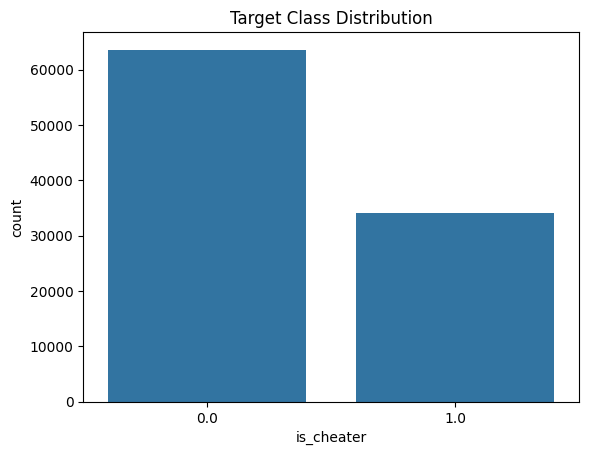

Cheater ratio: is_cheater
0.0    0.650847
1.0    0.349153
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x='is_cheater', data=df)
plt.title("Target Class Distribution")
plt.show()

cheat_ratio = df['is_cheater'].value_counts(normalize=True)
print("Cheater ratio:", cheat_ratio)

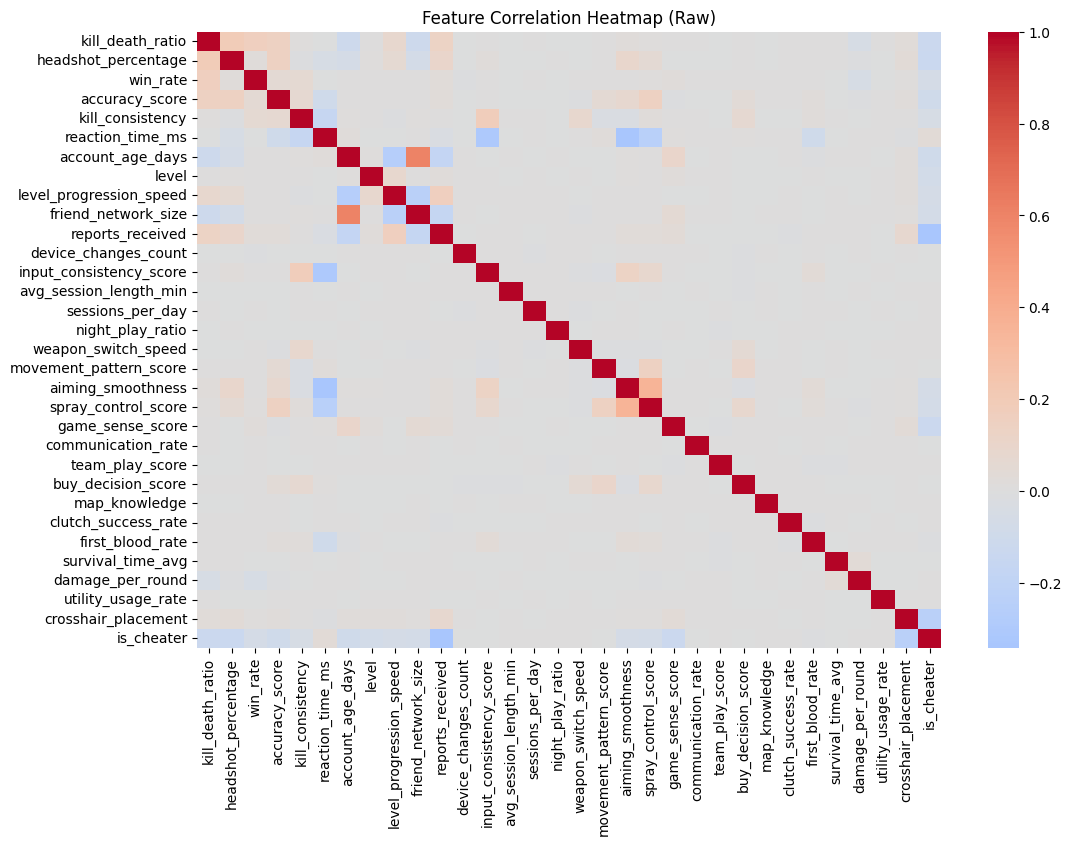

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (Raw)")
plt.show()

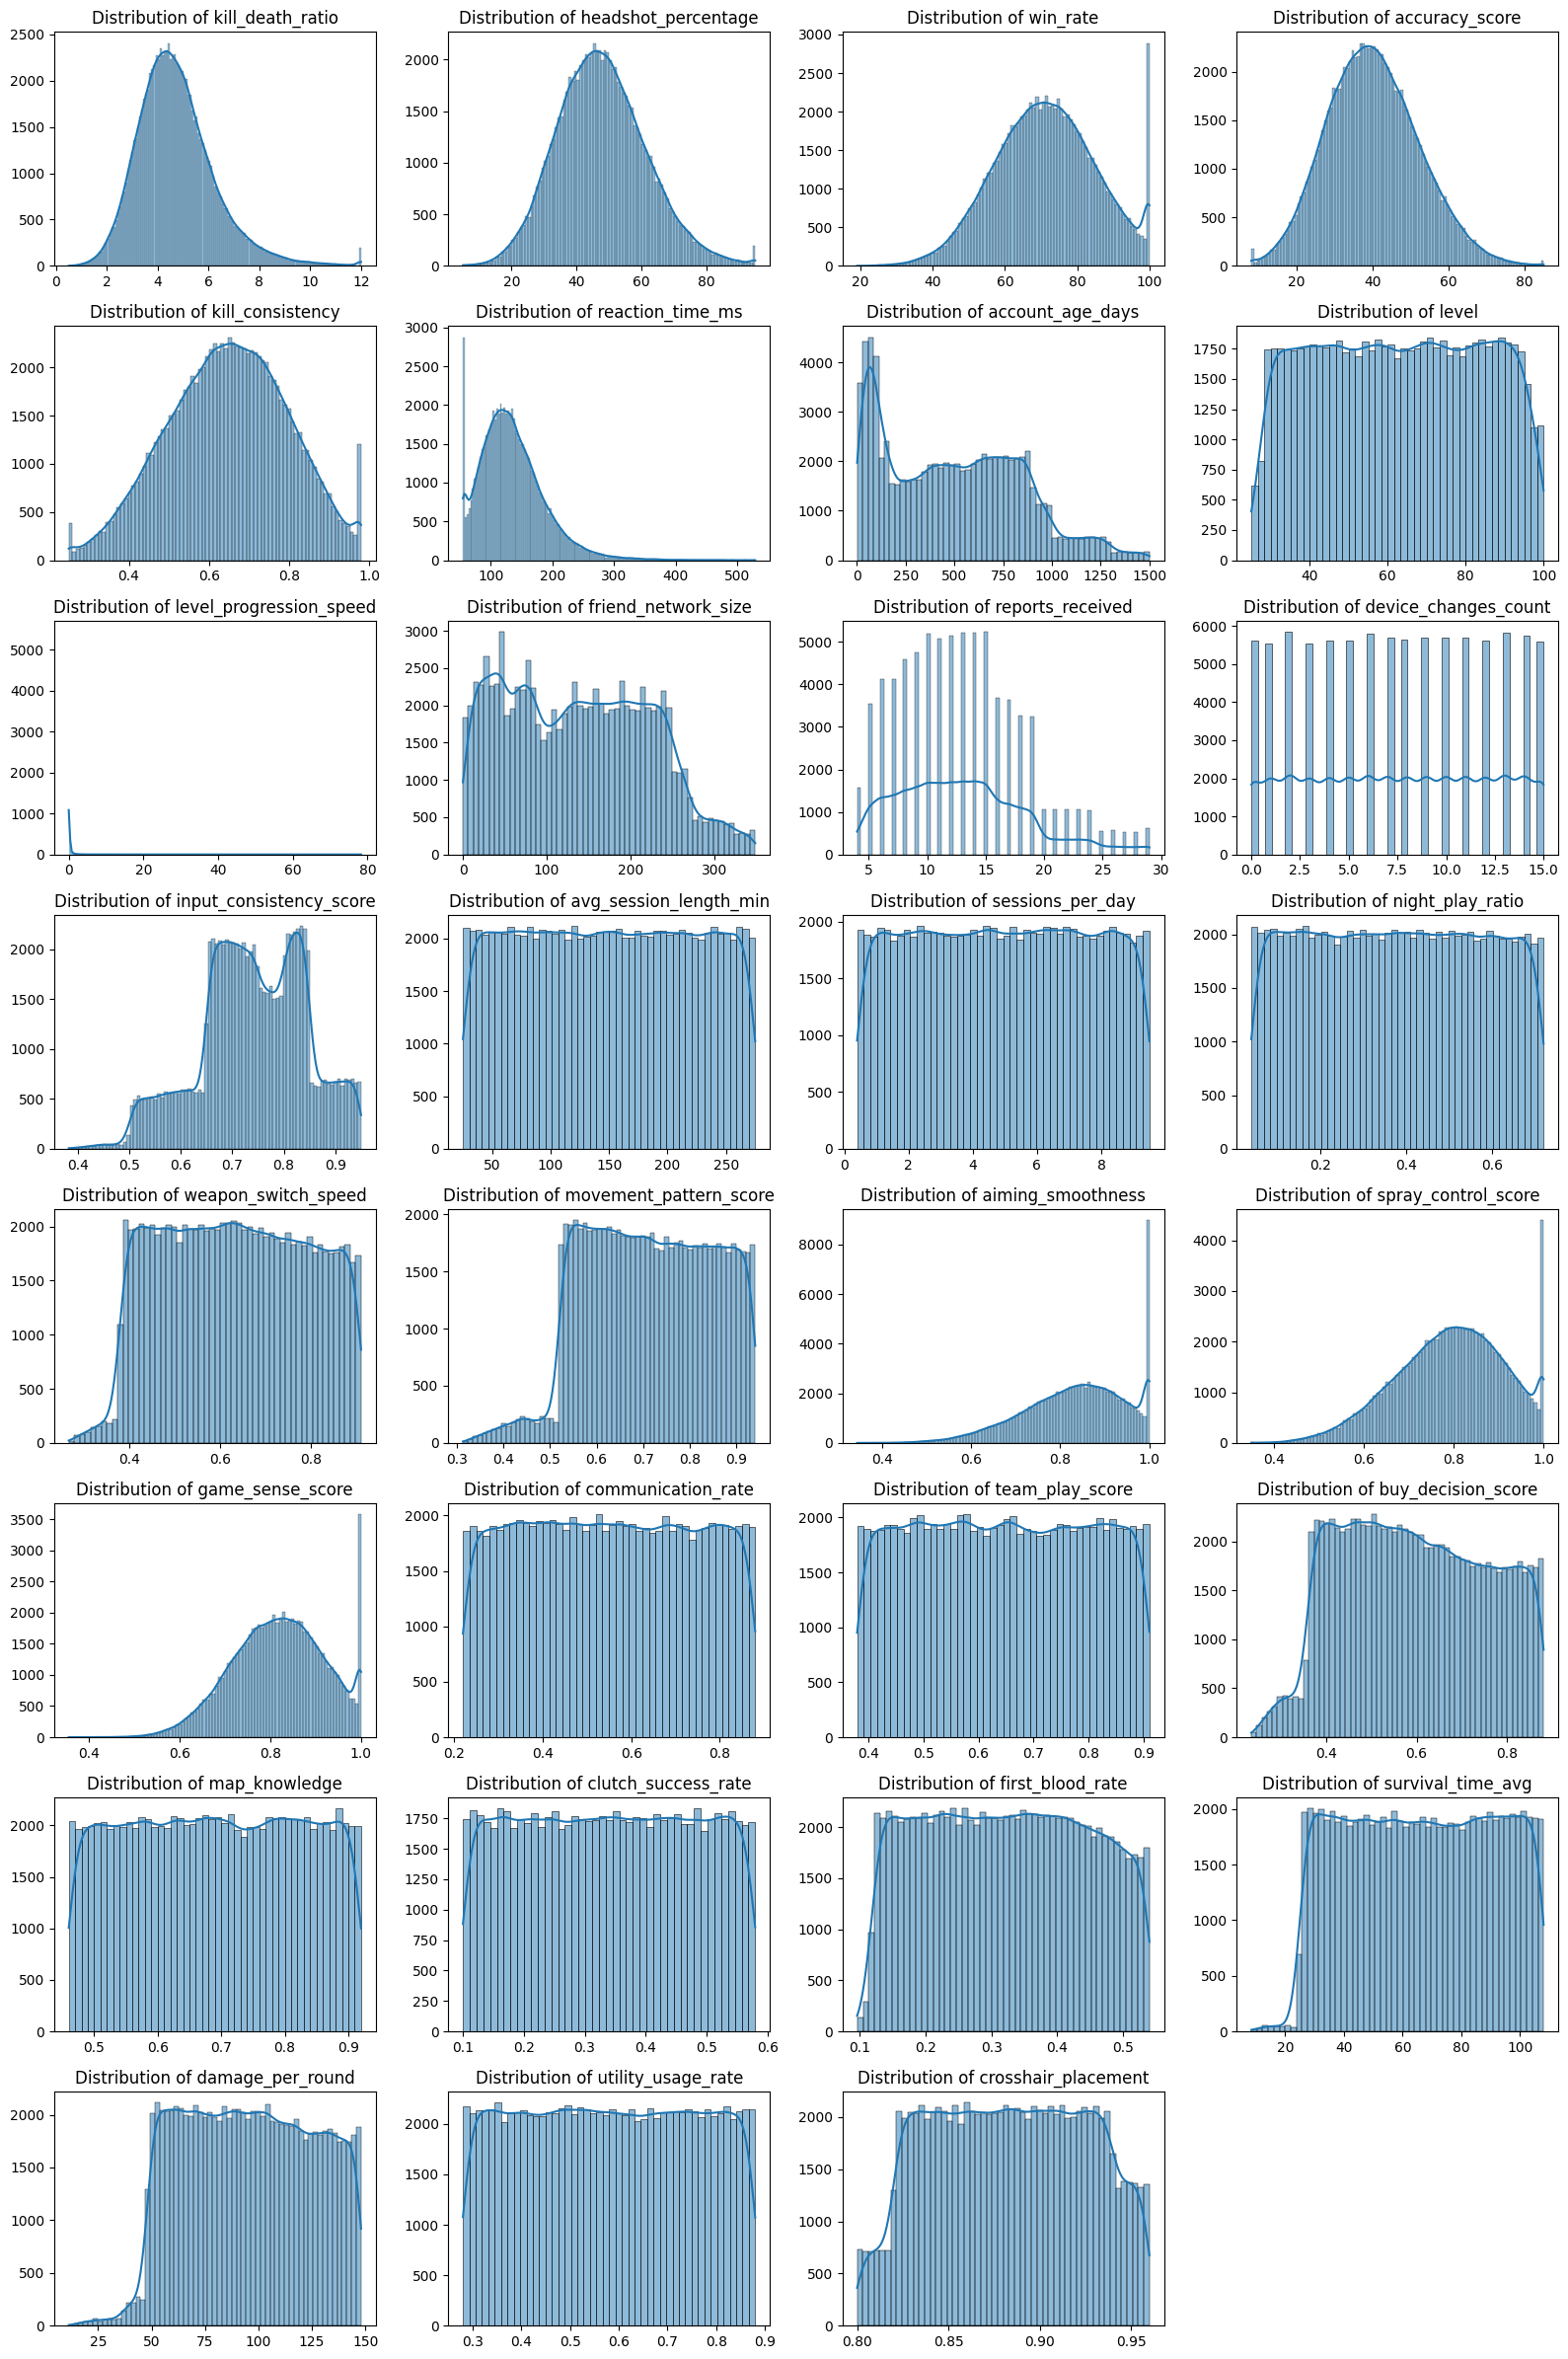

In [ ]:
continuous_features = df.select_dtypes(include=np.number).columns.tolist()
if 'is_cheater' in continuous_features:
    continuous_features.remove('is_cheater')
if 'id' in continuous_features:
    continuous_features.remove('id')
if 'player_id' in continuous_features:
    continuous_features.remove('player_id')

n_features = len(continuous_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(continuous_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

## Feature Engineer

> Inspired by **Cheat Detection in a Multiplayer First-Person Shooter Using Artificial Intelligence Tools** by University of Johannesburg, South Africa

In [ ]:
def feature_extractions(df):
  # --- Efficiency & Aim Features ---
  df["kill_efficiency"] = df["kill_death_ratio"] * df["accuracy_score"]
  df["headshot_ratio_to_accuracy"] = df["headshot_percentage"] / (df["accuracy_score"] + 1e-6)
  df["reaction_accuracy_ratio"] = df["accuracy_score"] / (df["reaction_time_ms"] + 1e-6)
  df["damage_efficiency"] = df["damage_per_round"] / (df["survival_time_avg"] + 1e-6)

  # --- Stability & Consistency ---
  df["performance_stability"] = df["kill_consistency"] * df["input_consistency_score"]
  df["reports_per_day"] = df["reports_received"] / (df["account_age_days"] + 1)
  df["device_change_rate"] = df["device_changes_count"] / (df["account_age_days"] + 1)
  df["session_intensity"] = df["sessions_per_day"] * df["avg_session_length_min"]

  # --- Behavioral Ratios ---
  df["performance_per_account_age"] = (
      (df["kill_death_ratio"] + df["accuracy_score"] + df["win_rate"]) / (df["account_age_days"] + 1)
  )
  df["input_to_accuracy_ratio"] = df["input_consistency_score"] / (df["accuracy_score"] + 1e-6)
  df["friendliness_ratio"] = (
      df["communication_rate"] * df["team_play_score"] / (df["reports_per_day"] + 1e-6)
  )
  return df

df = feature_extractions(df)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

## Post Feature Engineering EDA

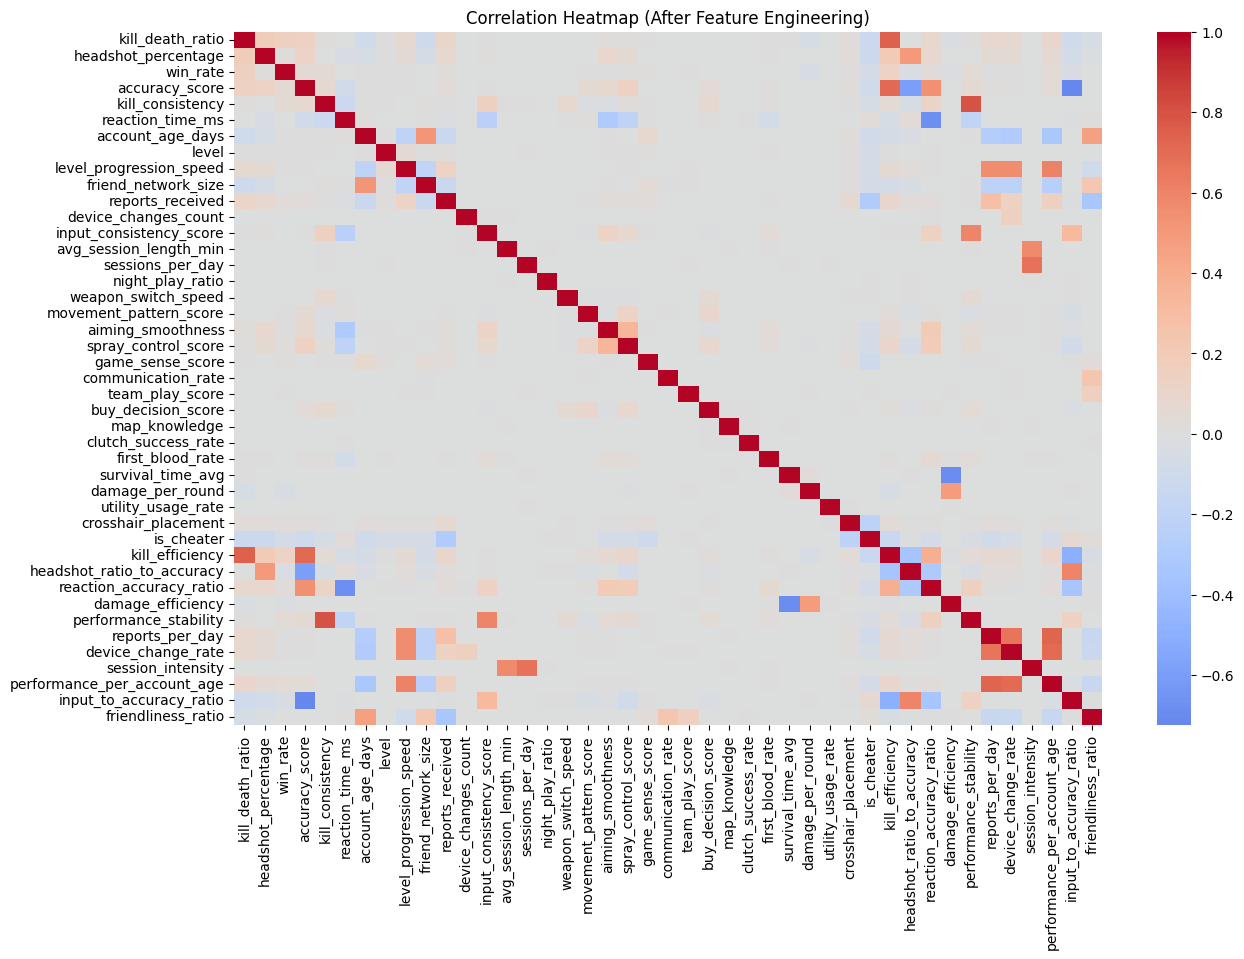

In [ ]:
plt.figure(figsize=(14,9))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (After Feature Engineering)")
plt.show()

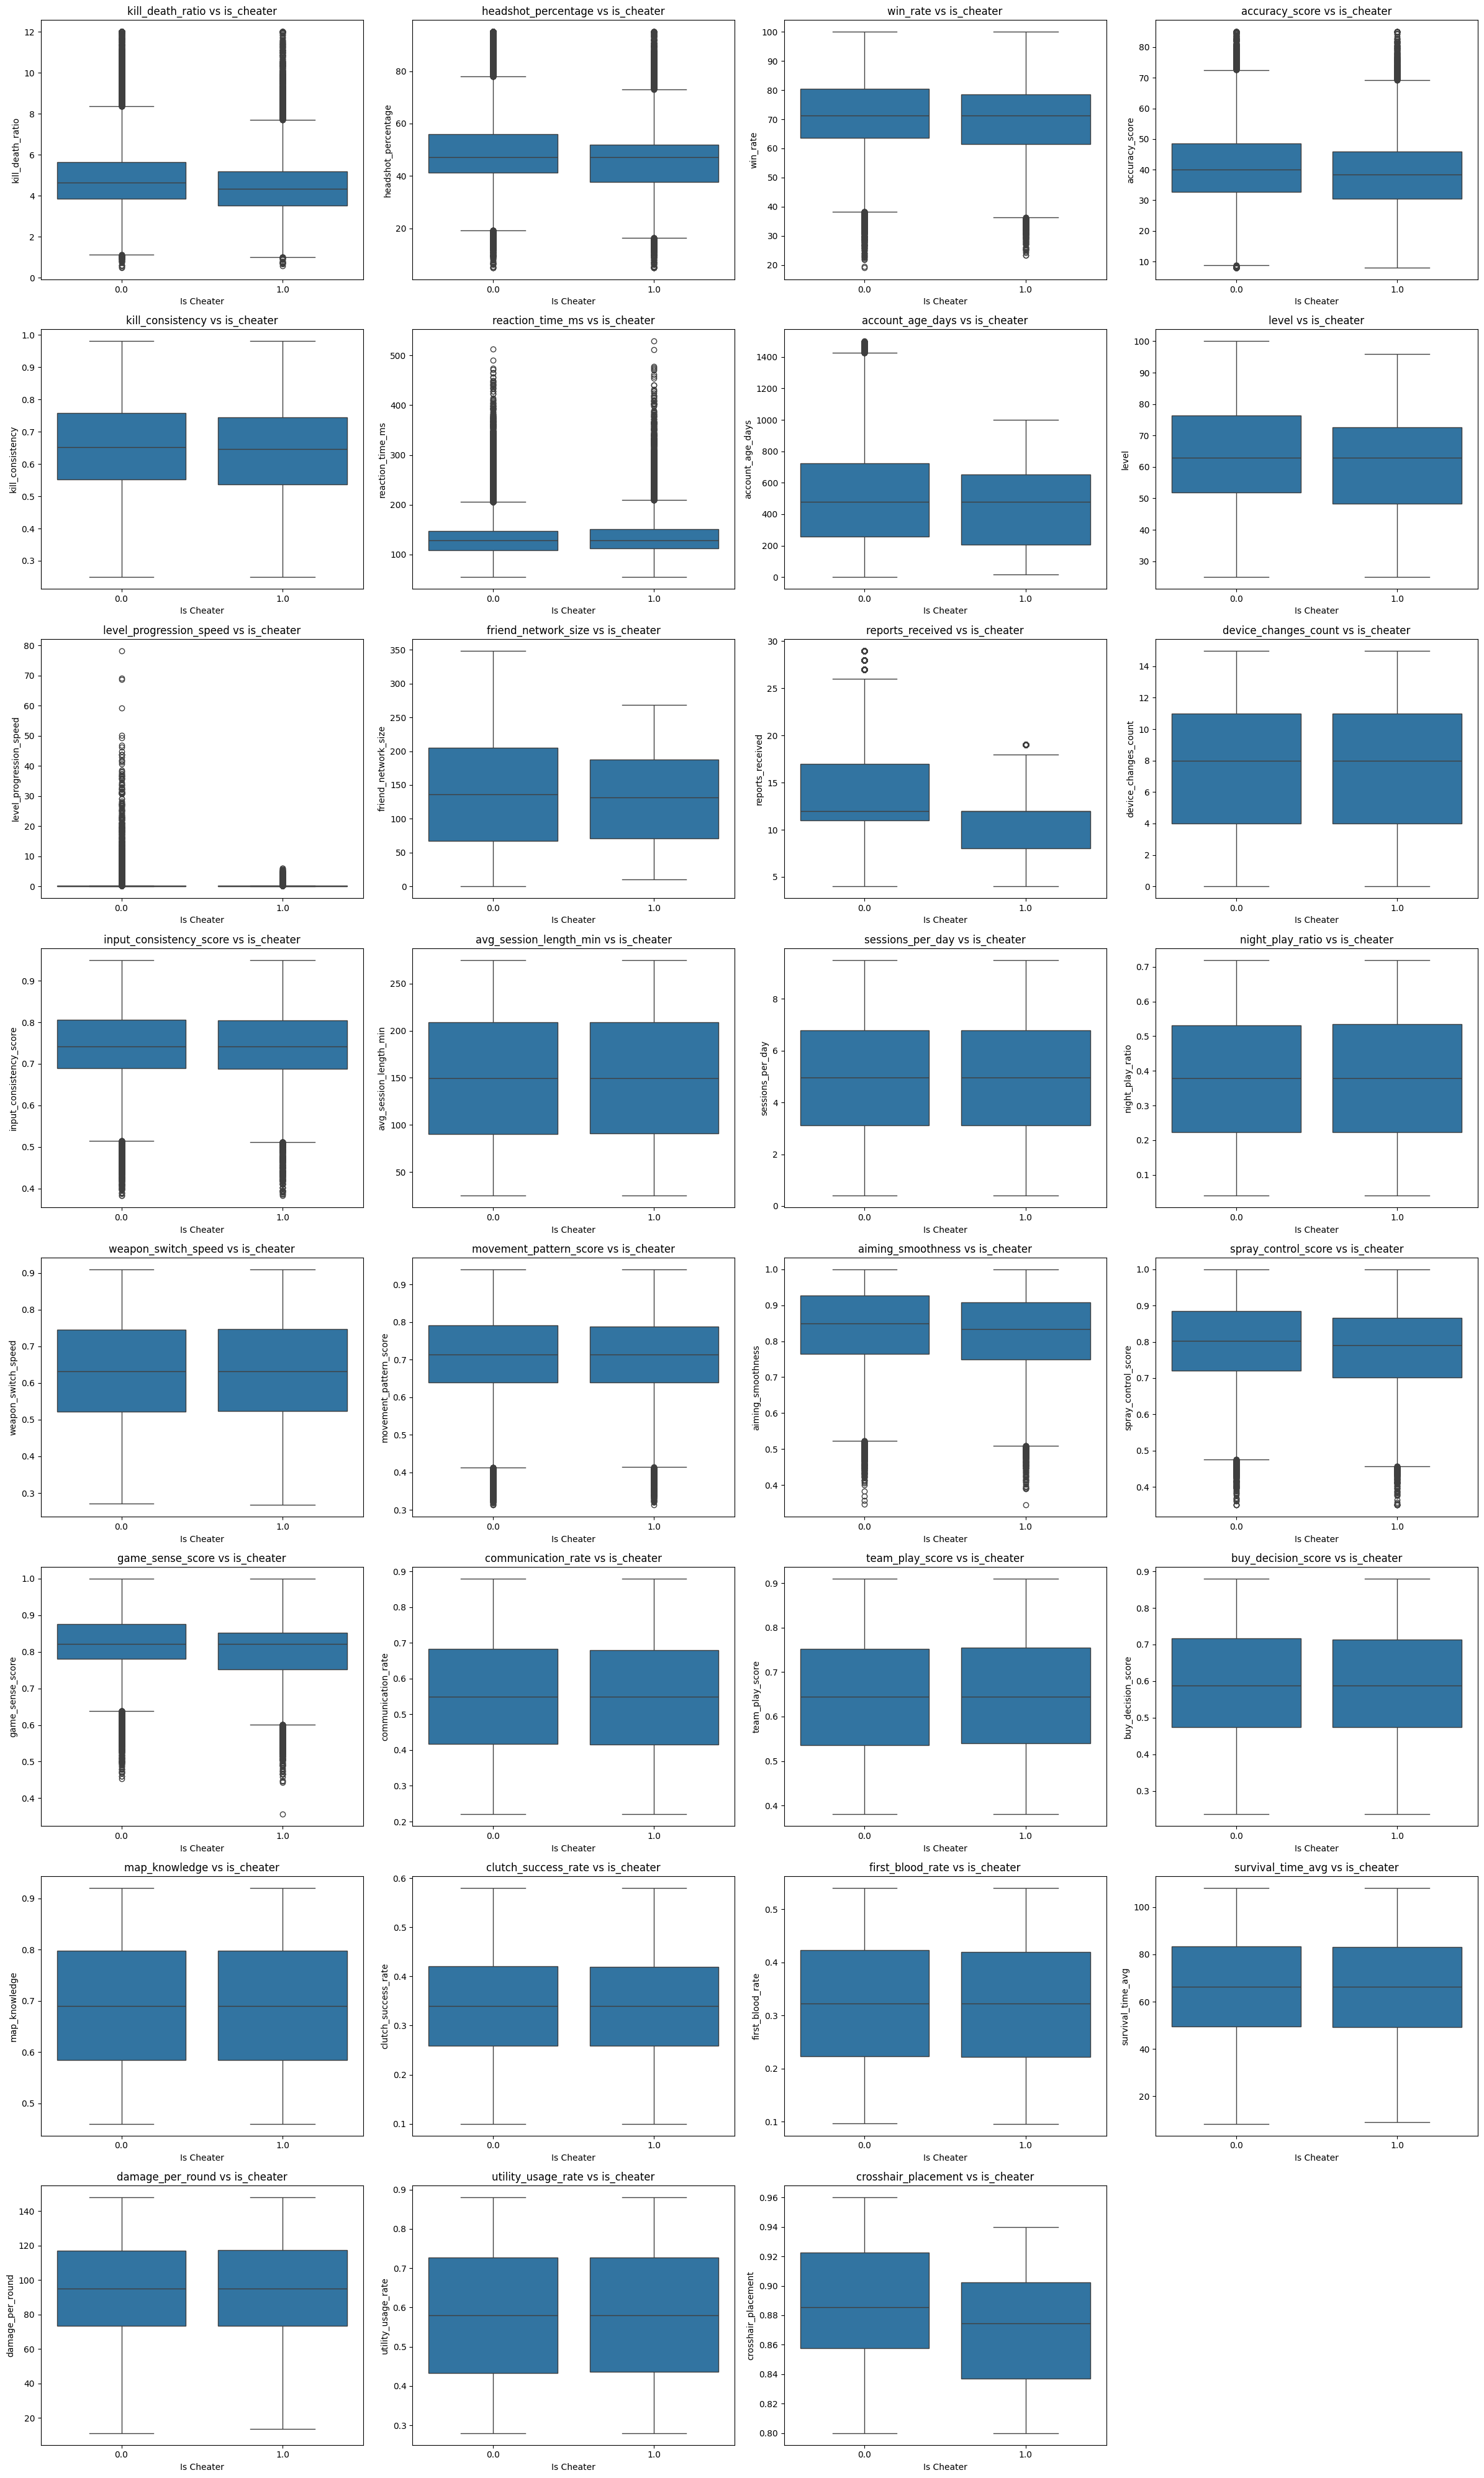

In [ ]:
important_feats = [
    'kill_death_ratio', 'headshot_percentage', 'win_rate', 'accuracy_score',
    'kill_consistency', 'reaction_time_ms', 'account_age_days', 'level',
    'level_progression_speed', 'friend_network_size', 'reports_received',
    'device_changes_count', 'input_consistency_score',
    'avg_session_length_min', 'sessions_per_day', 'night_play_ratio',
    'weapon_switch_speed', 'movement_pattern_score', 'aiming_smoothness',
    'spray_control_score', 'game_sense_score', 'communication_rate',
    'team_play_score', 'buy_decision_score', 'map_knowledge',
    'clutch_success_rate', 'first_blood_rate', 'survival_time_avg',
    'damage_per_round', 'utility_usage_rate', 'crosshair_placement'
]

n_features = len(important_feats)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 5))

for i, f in enumerate(important_feats):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='is_cheater', y=f, data=df)
    plt.title(f"{f} vs is_cheater")
    plt.xlabel("Is Cheater")
    plt.ylabel(f)

plt.tight_layout()
plt.show()

## Redundancy Features

In [ ]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Dropped:", to_drop)

Dropped: ['performance_stability']


## Feature Importance

(99872, 34)
(1448, 34)


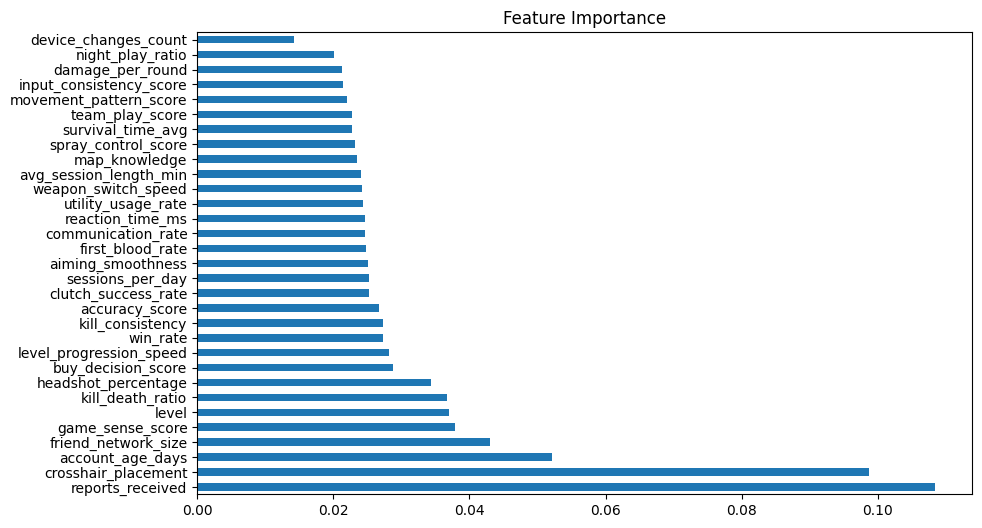

Index(['kill_death_ratio', 'headshot_percentage', 'win_rate', 'accuracy_score',
       'kill_consistency', 'reaction_time_ms', 'account_age_days', 'level',
       'level_progression_speed', 'friend_network_size', 'reports_received',
       'device_changes_count', 'input_consistency_score',
       'avg_session_length_min', 'sessions_per_day', 'night_play_ratio',
       'weapon_switch_speed', 'movement_pattern_score', 'aiming_smoothness',
       'spray_control_score', 'game_sense_score', 'communication_rate',
       'team_play_score', 'buy_decision_score', 'map_knowledge',
       'clutch_success_rate', 'first_blood_rate', 'survival_time_avg',
       'damage_per_round', 'utility_usage_rate', 'crosshair_placement'],
      dtype='object')


In [ ]:
df = pd.read_csv('task1/train.csv')
print(df.shape)
df = df.dropna()
print(df.shape)

X = df.drop(columns=["id", "player_id", "is_cheater"])
y = df["is_cheater"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='barh', figsize=(10,6))
plt.title("Feature Importance")
plt.show()

selected_features = importance[importance > 0.01].index
print(selected_features)

## Data Characteristics for Binary Classification

- **Target Variable**
  - `is_cheater` is binary: 0.0 (non-cheater) and 1.0 (cheater).
  - Suitable for binary classification tasks.

- **Class Imbalance**
  - Approximately 65% non-cheaters (0.0) and 35% cheaters (1.0).
  - Imbalance should be addressed during model training:
    - Techniques: oversampling, undersampling, or adjusting class weights.
    - Prevents bias towards the majority class.

## Feature Relevance and Preprocessing

- **Missing Values**
  - Many features have significant missing values.
  - Median imputation used as a simple baseline strategy.
  - Proper imputation is crucial for robust classification.

- **Feature Distributions**
  - Histograms help understand feature characteristics.
  - Some features may naturally separate classes.
  - Others may require transformations (e.g., `PowerTransformer`) for better model performance.

- **Feature Engineering**
  - Created features:
    - `kill_efficiency`
    - `headshot_ratio_to_accuracy`
    - `reaction_accuracy_ratio`
    - Behavioral ratios: `friendliness_ratio`, `reports_per_day`, etc.
  - Engineered features aim to enhance predictive power by combining raw data meaningfully.

- **Correlation Analysis**
  - Initial correlation heatmap identifies feature relationships.
    - Highly correlated features can lead to multicollinearity.
  - Post-feature engineering heatmap shows interactions between new features.
  - Identifying features strongly correlated with `is_cheater` is beneficial.

- **Feature vs. Target Boxplots**
  - Boxplots visualize distributions of features for each class.
  - Features with clear class separation are strong candidates for classification.

- **Redundancy**
  - `performance_stability` is highly correlated with other features.
  - Removing redundant features simplifies the model and can improve interpretability.

## Feature Importance

- **Random Forest Importance**
  - Analysis (on reduced dataset using `dropna()`) indicated all original features had importance > 0.01.
  - Suggests a wide range of player statistics help distinguish cheaters from non-cheaters.
  - Re-running importance on the fully imputed and engineered dataset is recommended for accurate insights.

## Summary

- Clear binary target with class imbalance.
- Features contain missing values requiring careful imputation.
- Feature engineering can create more discriminative variables.
- Boxplots reveal features that differentiate between classes.
- Initial feature importance analysis guides selection or weighting in models.
